# The evolution of the super-cited

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Citation table

We take cites from 1990 to 2019 avoiding self-cites.

In [2]:
cite = pd.read_csv("../data/processed/cites.csv")

cite = cite[(cite.t_year >= 1990) & (cite.t_year < 2020)]
cite = cite[(cite.s_year >= 1990) & (cite.s_year < 2020)]

cite = cite[cite.target != cite.source]

In [3]:
papers = pd.read_csv("../data/processed/adjacency_papers.csv")

papers = papers[(papers.t_year >= 1990) & (papers.t_year < 2020)]
papers = papers[(papers.s_year >= 1990) & (papers.s_year < 2020)]

papers = papers[papers.target != papers.source]

### Authors table

There are two author tables: 

1. One with the comparable groups A and B (`people`) and 
2. the one with the all the authors found in the RePEc repository (`all_people`).

In [4]:
people = pd.read_csv("../data/processed/network_people.csv")
all_people = pd.read_csv("../data/processed/people.csv")

### Places table

We use the institution to infer the place of work of the authors. We have:

1. The region (continent)
2. The sub-region (sub-continent)
3. Country 3-letter code
4. The institution's name

In [5]:
places = pd.read_csv("../data/processed/institution.csv")

places = places[['Handle', 'Primary-Name', 'alpha-3', 'region', 'sub-region']].set_index("Handle")

### Adding place of work to people

In [6]:
all_people = pd.merge(all_people,
                  places,
                  left_on="Workplace-Institution",
                  right_index=True,
                  how="left")

# all_people = all_people[all_people.region.notna()]

### Adding gender to the citation table

We have two genders for each cite:

1. Gender of the source (`gender_s`)
3. Gender of the target (`gender`)

In [7]:
cite = pd.merge(cite,
                all_people[["Short-Id", "gender"]],
                how="left",
                left_on="target",
                right_on="Short-Id")

cite = pd.merge(cite,
                all_people[["Short-Id", "gender"]].rename(columns={"gender":"gender_s"}),
                how="left",
                left_on="source",
                right_on="Short-Id")

Let's remove the citations without the gender of the target from the table.

In [8]:
cite = cite[cite.gender.notna()]
cite = cite[cite.gender_s.notna()]

## Super-cited researchers

Let's get some basic statistics of the super-cited researchers in our citation network.

In [9]:
G = nx.from_pandas_edgelist(cite,
                            source='source',
                            target='target',
                            create_using=nx.DiGraph)

In [10]:
len(G)

36665

In [11]:
degree = pd.DataFrame(G.in_degree(), columns=["author", "degree"])
mu = degree.degree.mean()
r = degree.degree.quantile(.75) - degree.degree.quantile(.25)

In [12]:
super_cited = degree[degree.degree >= mu + 1.5 * r].author.unique()
cite_sc = cite[cite.target.isin(super_cited)]

In [13]:
cite[cite.target.isin(super_cited)].shape[0] / cite.shape[0]

0.7304504753584287

In [14]:
len(super_cited)

4111

In [15]:
cite.head()

,paper,target,t_year,t_journal,source,s_year,s_journal,Short-Id_x,gender,Short-Id_y,gender_s
0,repec:aag:wpaper:v:22:y:2018:i:1:p:180-203,pal66,2018.0,repec:aag:wpaper,pmc90,2019.0,repec:gam:jsusta,pal66,male,pmc90,male
1,repec:aag:wpaper:v:22:y:2018:i:1:p:180-203,pmc90,2018.0,repec:aag:wpaper,pal66,2019.0,repec:gam:jsusta,pmc90,male,pal66,male
3,repec:abz:journl:y:2015:id:26,pba1182,2015.0,repec:abz:journl,pze104,2016.0,repec:abz:journl,pba1182,female,pze104,male
4,repec:abz:journl:y:2015:id:26,pze104,2015.0,repec:abz:journl,pba1182,2016.0,repec:abz:journl,pze104,male,pba1182,female
5,repec:acb:agenda:v:10:y:2003:i:1:p:27-41,pfi172,2003.0,repec:acb:agenda,pwh34,2010.0,repec:bla:ecorec,pfi172,male,pwh34,male


In [16]:
cite = cite.drop(['Short-Id_x', 'Short-Id_y'], axis=1)

In [17]:
cite = pd.merge(cite, people[['Short-Id', 'group']].rename(columns={'Short-Id': 'target',
                                                     'group': 'group_t'}),
         how='left',
         on='target')

In [18]:
cite = pd.merge(cite, people[['Short-Id', 'group']].rename(columns={'Short-Id': 'source',
                                                     'group': 'group_s'}),
         how='left',
         on='source')

In [19]:
cite['super_cited_t'] = False
cite['super_cited_s'] = False

In [20]:
cite.loc[cite.target.isin(super_cited), 'super_cited_t'] = True

In [21]:
cite.loc[cite.source.isin(super_cited), 'super_cited_s'] = True

In [22]:
cite.to_csv('../data/processed/cites_2.csv', index=False)

# Yearly evolution in super-cited researchers

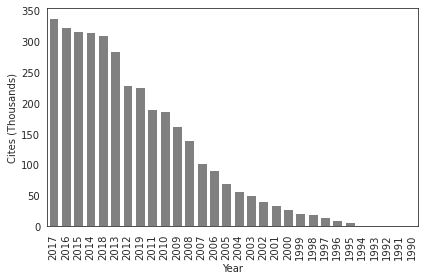

In [23]:
cite['s_year'] = cite['s_year'].astype(int).astype(str)

Y = cite['s_year'].value_counts()

with sns.axes_style("white"):
    sns.barplot(x=Y.index, y=Y.values/1000, color='gray')
plt.xticks(rotation=90)
plt.ylabel("Cites (Thousands)")
plt.xlabel("Year")
plt.tight_layout()
plt.savefig('../figures/citation_distribution.png', dpi=300);

In [39]:
scs = []
years = []
super_cited = []
for year in [2000, 2003] + list(range(2005, 2020)):
    years.append(year)
    if year == 2000:
        chunk = cite[cite.t_year <= year]
    elif year == 2003:
        chunk = cite[(cite.t_year > 2000) & (cite.t_year <= 2003)]
    elif year == 2005:
        chunk = cite[(cite.t_year > 2003) & (cite.t_year <= 2005)]
    else:
        chunk = cite[cite.t_year == year]
    G_year = nx.from_pandas_edgelist(chunk,
                                     source="source",
                                     target="target",
                                     create_using=nx.DiGraph)
    degree = pd.DataFrame(G_year.in_degree(), columns=["author", "degree"])
    mu = degree.degree.mean()
    r = degree.degree.quantile(.75) - degree.degree.quantile(.25)
    scited = degree[degree.degree >= mu + 1.5 * r].author.unique()
    super_cited.append(scited)
    prop_f = all_people[all_people['Short-Id'].isin(scited)].gender.value_counts(normalize=True).loc['female']
    scs.append(prop_f)
df = pd.DataFrame({"Female proportion": scs, "Year": years})

In [40]:
df['Year'] = df['Year'].astype(str)

In [41]:
df

,Female proportion,Year
0,0.107898,2000
1,0.135417,2003
2,0.152044,2005
3,0.149546,2006
4,0.147813,2007
5,0.167776,2008
6,0.164991,2009
7,0.170986,2010
8,0.164720,2011
9,0.153397,2012


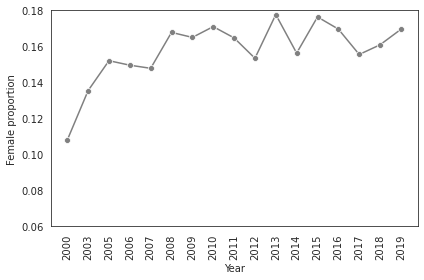

In [26]:
with sns.axes_style('white'):
    sns.lineplot(x="Year", y="Female proportion", data=df, marker="o", color="gray")
plt.xticks(rotation=90);
plt.ylim([0.06, 0.18])
plt.tight_layout()
plt.savefig('../figures/female_proportion_target.png', dpi=300);

In [27]:
cite["s_year"] = cite["s_year"].astype(int)

In [28]:
scs = []
years = []
super_cited = []
for year in [2000, 2003] + list(range(2005, 2020)):
    years.append(year)
    if year == 2000:
        chunk = cite[cite.s_year <= year]
    elif year == 2003:
        chunk = cite[(cite.s_year > 2000) & (cite.s_year <= 2003)]
    elif year == 2005:
        chunk = cite[(cite.s_year > 2003) & (cite.s_year <= 2005)]
    else:
        chunk = cite[cite.s_year == year]
    G_year = nx.from_pandas_edgelist(chunk,
                                     source="source",
                                     target="target",
                                     create_using=nx.DiGraph)
    degree = pd.DataFrame(G_year.in_degree(), columns=["author", "degree"])
    mu = degree.degree.mean()
    r = degree.degree.quantile(.75) - degree.degree.quantile(.25)
    scited = degree[degree.degree >= mu + 1.5 * r].author.unique()
    super_cited.append(scited)
    prop_f = all_people[all_people['Short-Id'].isin(scited)].gender.value_counts(normalize=True).loc['female']
    scs.append(prop_f)
df = pd.DataFrame({"Female proportion": scs, "Year": years})

In [29]:
df['Year'] = df['Year'].astype(str)

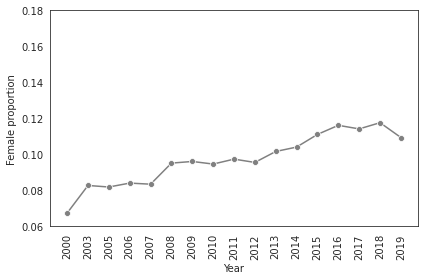

In [21]:
with sns.axes_style('white'):
    sns.lineplot(x="Year", y="Female proportion", data=df, marker="o", color="gray")
plt.xticks(rotation=90);
plt.ylim([0.06, 0.18])
plt.tight_layout()
plt.savefig('../figures/female_proportion_source.png', dpi=300);

## Yearly mean number of papers

In [22]:
article = pd.read_csv("../data/processed/article.csv")

In [23]:
mean_arts = []
years = []
gender = []
for year in list(range(1990, 2020)):
    chunk = article[article.year == year]
    narts = chunk.groupby(['Short-Id', 'gender']).size().rename('n').reset_index()
    mean_arts.append(narts[narts.gender=='female'].n.mean())
    gender.append('Female')
    mean_arts.append(narts[narts.gender=='male'].n.mean())
    gender.append('Male')
    years.extend([year, year])
df = pd.DataFrame({"Productivity": mean_arts, "Year": years, "Gender": gender})

In [24]:
df['Year'] = df['Year'].astype(str)

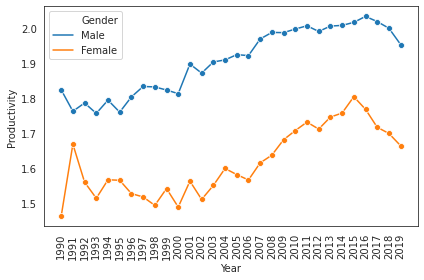

In [25]:
with sns.axes_style("white"):
    sns.lineplot(x='Year', y="Productivity", hue="Gender", data=df, marker="o",
                 hue_order=['Male', 'Female'])
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("../figures/productivity_gender.png", dpi=300)
# plt.ylim([1, 3])

## Impact per gender

Impact is defined as the mean number of cites received by paper 2 years prior.

In [26]:
cites_per_year = papers.groupby(['target', 's_year']).size().rename('n').reset_index()

In [27]:
cites_per_author = pd.merge(cites_per_year,
         cite[['paper', 'target', 'gender', 't_year']].rename(columns={"target": 'author'}).drop_duplicates(),
         left_on="target",
         right_on="paper")

In [28]:
years = []
impact = []
gender = []
for year in list(range(1992, 2020)):
    chunk = cites_per_author[(cites_per_author.t_year==year-2) & (cites_per_author.s_year==year)]
    gens = chunk.groupby('gender').n.mean()
    impact.append(gens.loc['female'])
    gender.append('female')
    impact.append(gens.loc['male'])
    gender.append('male')
    years.extend([year, year])
df = pd.DataFrame({'Impact': impact, 'Gender': gender, 'Year': years})

In [29]:
df['Year'] = df['Year'].astype(str)

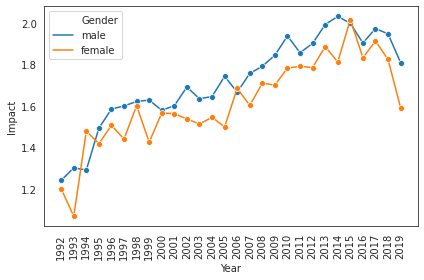

In [30]:
with sns.axes_style('white'):
    sns.lineplot(x='Year', y="Impact", hue="Gender", data=df, marker="o",
                 hue_order=['male', 'female'])
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("../figures/impact_per_gender.png", dpi=300)

## Without the super-cited

In [36]:
years = []
super_cited = []
for year in list(range(1990, 2020)):
    years.append(year)
    chunk = cite[cite.s_year == year]
    G_year = nx.from_pandas_edgelist(chunk,
                                     source="source",
                                     target="target",
                                     create_using=nx.DiGraph)
    degree = pd.DataFrame(G_year.in_degree(), columns=["author", "degree"])
    mu = degree.degree.mean()
    r = degree.degree.quantile(.75) - degree.degree.quantile(.25)
    scited = degree[degree.degree >= mu + 1.5 * r].author.unique()
    super_cited.append(scited)

### Productivity

In [40]:
mean_arts = []
years = []
gender = []
for i, year in enumerate(list(range(1990, 2020))):
    chunk = article[(article.year == year) & (~article['Short-Id'].isin(super_cited[i]))]
    narts = chunk.groupby(['Short-Id', 'gender']).size().rename('n').reset_index()
    mean_arts.append(narts[narts.gender=='female'].n.mean())
    gender.append('Female')
    mean_arts.append(narts[narts.gender=='male'].n.mean())
    gender.append('Male')
    years.extend([year, year])
df = pd.DataFrame({"Productivity": mean_arts, "Year": years, "Gender": gender})

In [41]:
df['Year'] = df['Year'].astype(str)

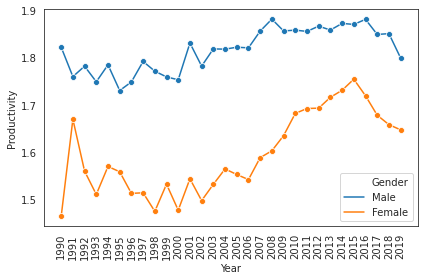

In [42]:
with sns.axes_style("white"):
    sns.lineplot(x='Year', y="Productivity", hue="Gender", data=df, marker="o",
                 hue_order=['Male', 'Female'])
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("../figures/productivity_gender_without_super_cited.png", dpi=300)
# plt.ylim([1, 3])

### Impact

In [ ]:
years = []
super_cited = []
for year in list(range(1992, 2020)):
    years.append(year)
    chunk = cite[cite.s_year == year]
    G_year = nx.from_pandas_edgelist(chunk,
                                     source="source",
                                     target="target",
                                     create_using=nx.DiGraph)
    degree = pd.DataFrame(G_year.in_degree(), columns=["author", "degree"])
    mu = degree.degree.mean()
    r = degree.degree.quantile(.75) - degree.degree.quantile(.25)
    scited = degree[degree.degree >= mu + 1.5 * r].author.unique()
    super_cited.append(scited)

In [32]:
years = []
impact = []
gender = []
for i, year in enumerate(list(range(1992, 2020))):
    chunk = cites_per_author[(cites_per_author.t_year==year-2) & (cites_per_author.s_year==year) & (
        ~cites_per_author.author.isin(super_cited[i]))]
    gens = chunk.groupby('gender').n.mean()
    impact.append(gens.loc['female'])
    gender.append('female')
    impact.append(gens.loc['male'])
    gender.append('male')
    years.extend([year, year])
df = pd.DataFrame({'Impact': impact, 'Gender': gender, 'Year': years})

In [33]:
df['Year'] = df['Year'].astype(str)

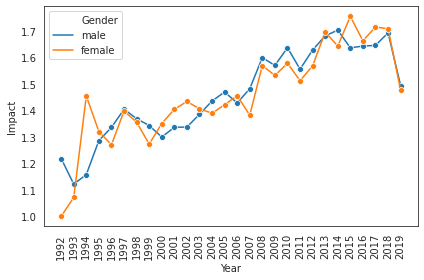

In [34]:
with sns.axes_style('white'):
    sns.lineplot(x='Year', y="Impact", hue="Gender", data=df, marker="o",
                 hue_order=['male', 'female'])
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("../figures/impact_per_gender_without_super_cited.png", dpi=300)

## Bias towards women